In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Green's Function

In [3]:
G_ds_path = 'Outputs/G_internal_var_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_internal_var_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

## Convolution

In [4]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

## CMIP6 1pct

In [5]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

## Emissions profile

In [6]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')


## RTCRE

In [7]:
RTCRE = xr.open_dataset('Outputs/RTCRE.nc')

# Settings and Define our Model Weights

In [8]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

In [9]:
type_color = utils.type_color

In [10]:
A = utils.A
ds_out = utils.ds_out

# Multiple options for path to 2 degrees C

In [11]:
T = 69 #years to 2 degrees for the global mean
cum_emis = emis_profile.sel(year = slice(0,T)).mean(dim = ['model']).sel(experiment = '1pct').sum()['emis'].values

In [12]:
cum_emis

array(1228.72974378)

In [13]:
#function for getting emissions at time, t, that matches the cumulative goal

def poly_fit_cumulative_emis(T, n, t, c):
    '''T is the years at which we reach a given cumulative emissions,
    n is the polynomial fit we want,
    t is the time range,
    c is the cumulative emissions goal'''
    T = T+0.5
    e = (c*(n+1)*t**n)/(T**(n+1))
    return(e)

In [14]:
#create our emissions based on polynomial values
n_range = [1/8,1/4,1/2,2,4,8]
e_range = {}
for n in n_range:
    e_range[n] = poly_fit_cumulative_emis(T, n, np.arange(0,90), cum_emis)

1228.7297437763739


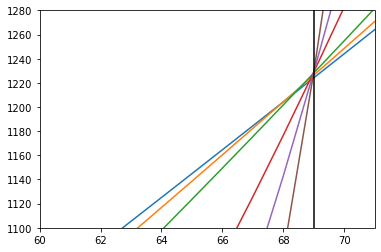

In [16]:
for n in n_range:
    plt.plot(e_range[n].cumsum())
print(emis_profile.sel(year = slice(0,T)).mean(dim = ['model']).sel(experiment = '1pct').sum()['emis'].values)
plt.xlim(60,71)
plt.ylim(1100,1280)
plt.axvline(69, color = 'k')

In [41]:
%%time

conv_2degC = {}
for m in G_ds.model.values:
    conv_2degC[m] = {}
    for p in G_ds.pulse_year.values:
        GF = G_ds.sel(pulse_year = p).sel(model = m).mean(dim = ['pulse_type'])
        conv_2degC[m][p] = {}
        for n in n_range:
            conv_2degC[m][p][n] = signal.convolve(np.array(GF.dropna(dim = 's')), e_range[n][..., None, None],'full')
            conv_2degC[m][p][n] = utils.np_to_xr(conv_2degC[m][p][n], GF, e_range[n])



CPU times: user 9min 32s, sys: 6min 16s, total: 15min 48s
Wall time: 15min 50s


In [43]:
conv_2degC_dict = {}
for m in conv_2degC.keys():
    conv_2degC_dict[m] = {}
    for p in conv_2degC[m].keys():
        conv_2degC_dict[m][p] = xr.concat([conv_2degC[m][p][n] for n in conv_2degC[m][p].keys()], 
                                    pd.Index([n for n in conv_2degC[m][p].keys()], name='polyfit'), coords='minimal')



In [51]:
for m in conv_2degC.keys():
    conv_2degC_dict[m] = xr.concat([conv_2degC_dict[m][p] for p in conv_2degC[m].keys()], 
                                    pd.Index([p for p in conv_2degC[m].keys()], name='pulse_year'), coords='minimal')

    
conv_2degC_ds = xr.concat([conv_2degC_dict[m] for m in conv_2degC_dict.keys()], 
                          pd.Index([p for p in conv_2degC_dict.keys()], name='model'), coords='minimal')


In [1]:
model_var = conv_2degC_ds.var(dim = ['model']).mean(dim = ['pulse_year','polyfit'])

NameError: name 'conv_2degC_ds' is not defined

In [ ]:
scenario_var = conv_2degC_ds.var(dim = ['polyfit']).mean(dim = ['pulse_year','model'])

In [ ]:
internal_var = conv_2degC_ds.var(dim = ['pulse_year']).mean(dim = ['polyfit','model'])

In [ ]:
total_var = internal_var + model_var + scenario_var

In [40]:
plt.stackplot(model_var['year'], 
              scenario_var/total_var,
              model_var/total_var,
              internal_var/total_var,
              labels = ['Scenario Variance', 'Model Variance', 'Internal Variance'],
             alpha = 0.7);
plt.legend(loc = 'lower right')
plt.xlim(0,90)
plt.ylim(0,1)
plt.ylabel('Percent of total Variance')
plt.xlabel('Year')
plt.savefig('figures/paper/supp_variance_model_2degrees.png', bbox_inches = 'tight')

<xarray.DataArray (s: 330, lat: 180, lon: 360)>
array([[[1.46173537e-27, 3.26735278e-27, 1.29033155e-27, ...,
         1.39909048e-27, 2.30911680e-27, 2.21356979e-27],
        [2.79542582e-27, 3.07987553e-27, 3.14212683e-27, ...,
         3.64920046e-27, 4.03032478e-27, 3.06689764e-27],
        [2.81724356e-27, 3.79039347e-27, 1.53712412e-27, ...,
         2.14537206e-27, 2.50013638e-27, 4.44958493e-27],
        ...,
        [1.99231386e-25, 2.80838370e-25, 2.64027882e-25, ...,
         2.55980742e-25, 1.43184624e-25, 1.79716732e-25],
        [2.34382818e-25, 1.97257046e-25, 2.29559981e-25, ...,
         2.03618507e-25, 2.86903000e-25, 1.66713317e-25],
        [1.64000981e-25, 1.31390322e-25, 2.44643942e-25, ...,
         2.10949438e-25, 1.79123068e-25, 2.86336569e-25]],

       [[2.35706322e-06, 2.35948652e-06, 2.36430482e-06, ...,
         2.35779613e-06, 2.36170763e-06, 2.35937622e-06],
        [1.87746963e-06, 1.87160451e-06, 1.87166562e-06, ...,
         1.91383835e-06, 1.90599080e-06, 1.89159585e-06],
        [1.71811874e-06, 1.70560829e-06, 1.70117086e-06, ...,
         1.74981106e-06, 1.73700683e-06, 1.72744191e-06],
...
        [2.11574344e+03, 2.11571128e+03, 2.08940011e+03, ...,
         2.15168030e+03, 2.15420474e+03, 2.13689885e+03],
        [3.33753693e+03, 3.37933138e+03, 3.36361385e+03, ...,
         3.26797190e+03, 3.31272293e+03, 3.32601540e+03],
        [5.90727949e+03, 5.93424418e+03, 5.91375609e+03, ...,
         5.90069235e+03, 5.89205815e+03, 5.89611796e+03]],

       [[9.41872549e+02, 9.45580644e+02, 9.46381042e+02, ...,
         9.36056050e+02, 9.36809386e+02, 9.39625630e+02],
        [8.99936432e+02, 9.07170380e+02, 9.08217467e+02, ...,
         8.60627450e+02, 8.75112954e+02, 8.88232153e+02],
        [7.50467158e+02, 7.66822112e+02, 7.81194990e+02, ...,
         6.99464367e+02, 7.18498970e+02, 7.34661271e+02],
        ...,
        [5.88392844e+02, 5.88379899e+02, 5.81113085e+02, ...,
         5.98336566e+02, 5.99031999e+02, 5.94249699e+02],
        [9.27531260e+02, 9.39145216e+02, 9.34795480e+02, ...,
         9.08185773e+02, 9.20620235e+02, 9.24321197e+02],
        [1.64210731e+03, 1.64960613e+03, 1.64391611e+03, ...,
         1.64026579e+03, 1.63786281e+03, 1.63899727e+03]]])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 321 322 323 324 325 326 327 328 329
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

## Specific locations

In [25]:
gmean_vline = np.abs((conv_ds.weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

In [27]:
#similar cumulative emissions
for n in n_range:
    for p in conv_2degC_ds.pulse_year.values:
        ax1.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(pulse_year = p).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
    plt.ylim(0,5)


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

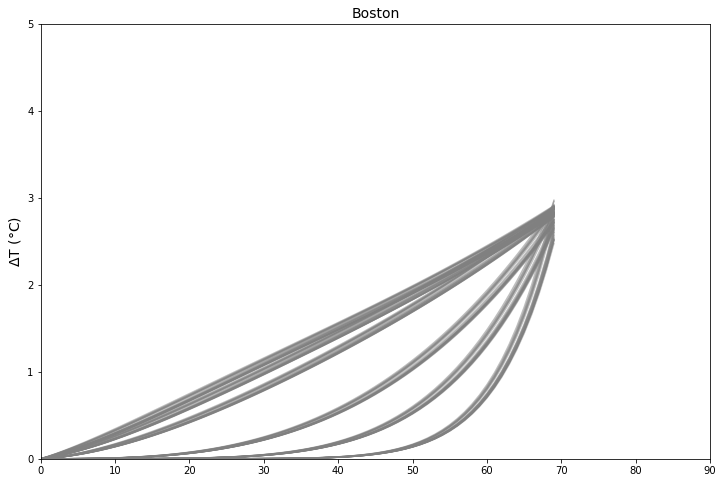

In [34]:
fig, ax1 = plt.subplots( figsize = [12,8], sharex = True, sharey = True)

##############################################################
lat_lon = {'lat': 42.3, 'lon': 360-71.1}
#1pct
# conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax1, color = type_color['emulator_1pct'], label = ' 1pctCO$_2$')
#ax1.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax1.set_title('Boston', fontsize = 14)
ax1.set_xlabel('', fontsize = 14)
ax1.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)

#global 2 degree C
# gmean_vline = np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
#     np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
#     np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
# ax1.axvline(gmean_vline, linestyle = "--", color = 'k')
# #local time when global 2 degree C
# gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values

#similar cumulative emissions
for p in conv_2degC_ds.pulse_year.values:
    for n in n_range:
        ax1.plot(conv_2degC_ds.sel(s = slice(0,69)).sel(polyfit = n).sel(pulse_year = p).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
    plt.ylim(0,5)
    

# ax1.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                  conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)


# local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
#                                    #conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
#                                    #conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
#                                    ])
# print(local_mean_spread)
# local_max = np.max(local_mean_spread)
# local_min = np.min(local_mean_spread)
# ax1.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2.16577331 2.17070097 2.17367769 2.09859923 1.89487939 1.4952252
 2.68540066]
[2.08198852 2.09678543 2.11445195 2.06301484 1.85717517 1.4572606
 2.35337096]
[1.36370824 1.35532331 1.33699221 1.2328087  1.10742855 0.89955502
 1.66480291]
[1.58713819 1.58439582 1.57461162 1.47582807 1.31349407 1.03154411
 1.77603013]


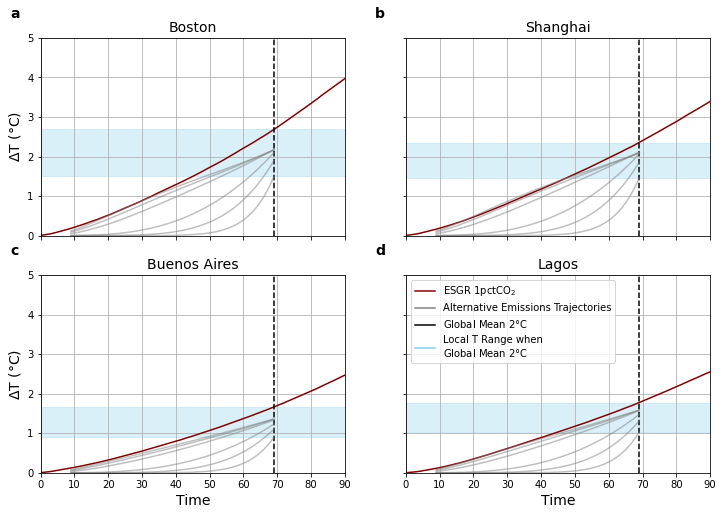

In [20]:
fig, [[ax1, ax2],[ ax3, ax4]] = plt.subplots(2,2, figsize = [12,8], sharex = True, sharey = True)

##############################################################
lat_lon = {'lat': 42.3, 'lon': 360-71.1}
#1pct
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax1, color = type_color['emulator_1pct'], label = ' 1pctCO$_2$')
#ax1.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax1.set_title('Boston', fontsize = 14)
ax1.set_xlabel('', fontsize = 14)
ax1.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)

#global 2 degree C
gmean_vline = np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
ax1.axvline(gmean_vline, linestyle = "--", color = 'k')
#local time when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values

#similar cumulative emissions
for n in n_range:
    ax1.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
plt.ylim(0,5)

# ax1.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                  conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)


local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                   #conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                   #conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax1.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)

##############################################################
lat_lon = {'lat': 31.2, 'lon': 121.5}

#ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax2, color = type_color['emulator_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax2, color = type_color['emulator_1pct'], label = ' 1pctCO$_2$')
#ax2.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.legend()
ax2.set_title('Shanghai', fontsize = 14)
ax2.set_xlabel('', fontsize = 14)
ax2.set_ylabel('', fontsize = 14)

#global 2 degree C
ax2.axvline(gmean_vline, linestyle = "--", color = 'k')
#local time when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values

#similar cumulative emissions
for n in n_range:
    ax2.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
plt.ylim(0,5)

# ax2.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                  conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)

local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                  # conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                  # conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax2.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)
##############################################################
lat_lon = {'lat': 34.6, 'lon': 360-58.4}

#ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax3, color = type_color['emulator_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax3, color = type_color['emulator_1pct'], label = ' 1pctCO$_2$')
#ax3.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax3.set_title('Buenos Aires', fontsize = 14)
ax3.set_xlabel('Time', fontsize = 14)
ax3.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)

#global 2 degree C
ax3.axvline(gmean_vline, linestyle = "--", color = 'k')
#local time when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values

#similar cumulative emissions
for n in n_range:
    ax3.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
plt.ylim(0,5)

# ax3.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                  conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)

local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                  # conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                  # conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax3.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)

##############################################################
lat_lon = {'lat': 6.5, 'lon': 3.4}

conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax4, color = type_color['emulator_1pct'], label = 'ESGR 1pctCO$_2$')
#ax4.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.ylim(0,8)
ax4.set_title('Lagos', fontsize = 14)
ax4.set_xlabel('Time', fontsize = 14)
ax4.set_ylabel('', fontsize = 14)

#global 2 degree C
ax4.axvline(gmean_vline, linestyle = "--", color = 'k')
#local temp when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values



#similar cumulative emissions
for n in n_range:
    ax4.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)

# ax4.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                 conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)

local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                  # conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                  # conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax4.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)

plt.ylim(0,5)


####### legend ##########
handles, labels = plt.gca().get_legend_handles_labels()
#local_2c =  Line2D([0], [0], label='Local 2$\degree$C', color='C0')  
global_2c = Line2D([0], [0], label='Global Mean 2$\degree$C', color='k')
local_global_2c = Line2D([0], [0], label='Local T Range when\nGlobal Mean 2$\degree$C', color='skyblue')
alt_emis = Line2D([0], [0], label='Alternative Emissions Trajectories', color='grey')


handles.extend([alt_emis, global_2c,local_global_2c])

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

    
plt.legend(handles=handles)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.savefig('figures/paper/figure5_locations_time.png', bbox_inches = 'tight', dpi = 300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


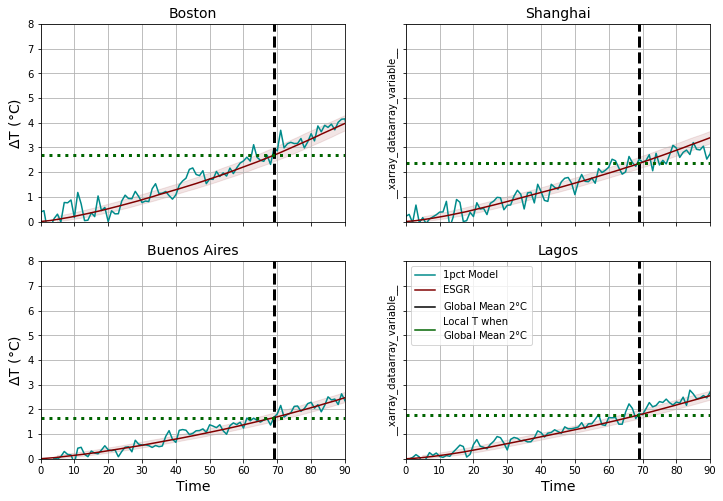

In [53]:
fig, [[ax1, ax2],[ ax3, ax4]] = plt.subplots(2,2, figsize = [12,8], sharex = True, sharey = True)

lat_lon = {'lat': 42.3, 'lon': 360-71.1}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax1, color = type_color['model_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax1, color = type_color['emulator_1pct'], label = '1pct Model')
ax1.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax1.set_title('Boston', fontsize = 14)
ax1.set_xlabel('', fontsize = 14)
ax1.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_vline = np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
ax1.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax1.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)

##############################################################
lat_lon = {'lat': 31.2, 'lon': 121.5}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax2, color = type_color['model_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax2, color = type_color['emulator_1pct'], label = '1pct Model')
ax2.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.legend()
ax2.set_title('Shanghai', fontsize = 14)
ax2.set_xlabel('', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
# ax2.axvline(vline,
#             linestyle = ':')
# ax2.axvspan(vline -5, vline +5, 0,10, alpha = 0.1)
ax2.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax2.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)

##############################################################
lat_lon = {'lat': 34.6, 'lon': 360-58.4}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax3, color = type_color['model_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax3, color = type_color['emulator_1pct'], label = '1pct Model')
ax3.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax3.set_title('Buenos Aires', fontsize = 14)
ax3.set_xlabel('Time', fontsize = 14)
ax3.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

ax3.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax3.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)


##############################################################
lat_lon = {'lat': 6.5, 'lon': 3.4}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax4, color = type_color['model_1pct'], label = '1pct Model')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax4, color = type_color['emulator_1pct'], label = 'ESGR')
ax4.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.ylim(0,8)
ax4.set_title('Lagos', fontsize = 14)
ax4.set_xlabel('Time', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

ax4.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax4.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)

handles, labels = plt.gca().get_legend_handles_labels()
#local_2c =  Line2D([0], [0], label='Local 2$\degree$C', color='C0')  
global_2c = Line2D([0], [0], label='Global Mean 2$\degree$C', color='k')
local_global_2c = Line2D([0], [0], label='Local T when\nGlobal Mean 2$\degree$C', color='darkgreen')

handles.extend([global_2c,local_global_2c])

plt.legend(handles=handles)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.savefig('figures/talks/figure5_locations_time.png', bbox_inches = 'tight', dpi = 300)

In [54]:
#emissions to get to a level of warming
print(emis_profile.where(ds_dif['model'].isin(model_weights.model.values), drop = True).weighted(model_weights).mean(dim = 'model').sel(year = slice(0,np.squeeze(vline))).sum('year'))


<xarray.Dataset>
Dimensions:     (experiment: 2)
Coordinates:
    depth       float64 0.0
  * experiment  (experiment) object '1000gtc' '1pct'
Data variables:
    emis        (experiment) float64 1.057e+03 1.231e+03


In [55]:
gmean_vline = np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

lat_lon = {'lat': 42.3, 'lon': 360-71.1}
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values

print(vline)
print(gmean_hline.mean())


lat_lon = {'lat': 31.2, 'lon': 121.5}

vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values


print(vline)
print(gmean_hline.mean())

lat_lon = {'lat': 34.6, 'lon': 360-58.4}

vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values

print(vline)
print(gmean_hline.mean())


lat_lon = {'lat': 6.5, 'lon': 3.4}


vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values

print(vline)
print(gmean_hline.mean())


[56]
2.6905081350678017
[61]
2.3567635195252916
[78]
1.667796953158872
[75]
1.778194621448902


## Zero emissions Commitment

In [56]:
t = 80
yr_dif = 10
(conv_ds.sel(experiment = '1000gtc').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').weighted(A).mean(dim = ['lat','lon']) - 
conv_ds.sel(experiment = '1000gtc').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = 65).weighted(A).mean(dim = ['lat','lon']))

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(-0.02757228)
Coordinates:
    experiment  <U7 '1000gtc'
    s           int64 65

# Two trajectories with same cumulative emis

In [21]:
#https://climateactiontracker.org/global/temperatures/ for emissions trajectory

In [22]:
slow_decrease = np.concatenate([np.arange(10.,30., 1.), np.arange(30.,0.,-1.)])
slow_decrease = np.concatenate([slow_decrease, np.zeros(50)])


sudden_decrease = np.concatenate([np.arange(10.,70., 3.), np.arange(70.,0., -10.)])
sudden_decrease = np.concatenate([sudden_decrease, np.zeros(len(slow_decrease)-len(sudden_decrease))])


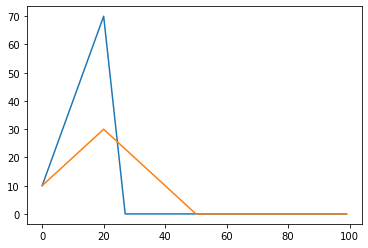

In [23]:
plt.plot(sudden_decrease)
plt.plot(slow_decrease)

In [24]:
mod_factor = np.cumsum(sudden_decrease)[-1]/np.cumsum(slow_decrease)[-1]

In [25]:
mod_factor

1.2280701754385965

In [26]:
slow_decrease[1:]*=mod_factor


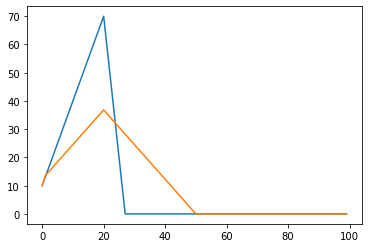

In [27]:
plt.plot(sudden_decrease)
plt.plot(slow_decrease)

In [28]:
dif = sudden_decrease.sum() - slow_decrease.sum()

In [29]:
slow_decrease[49] += dif/2

In [30]:
slow_decrease[50] += dif/2

In [31]:
%%time

GF = G_ds.weighted(G_model_weights).mean(dim = ['model', 'pulse_type'])

conv_sudden = signal.convolve(np.array(GF.dropna(dim = 's')), np.array(sudden_decrease)[..., None, None],'full')
conv_sudden = utils.np_to_xr(conv_sudden, GF, sudden_decrease)

conv_slow = signal.convolve(np.array(GF.dropna(dim = 's')), np.array(slow_decrease)[..., None, None],'full')
conv_slow = utils.np_to_xr(conv_slow, GF, slow_decrease)


CPU times: user 2.53 s, sys: 1.17 s, total: 3.7 s
Wall time: 3.71 s


In [35]:
TCRE = RTCRE.weighted(A).mean(dim = ['lat','lon'])['__xarray_dataarray_variable__']


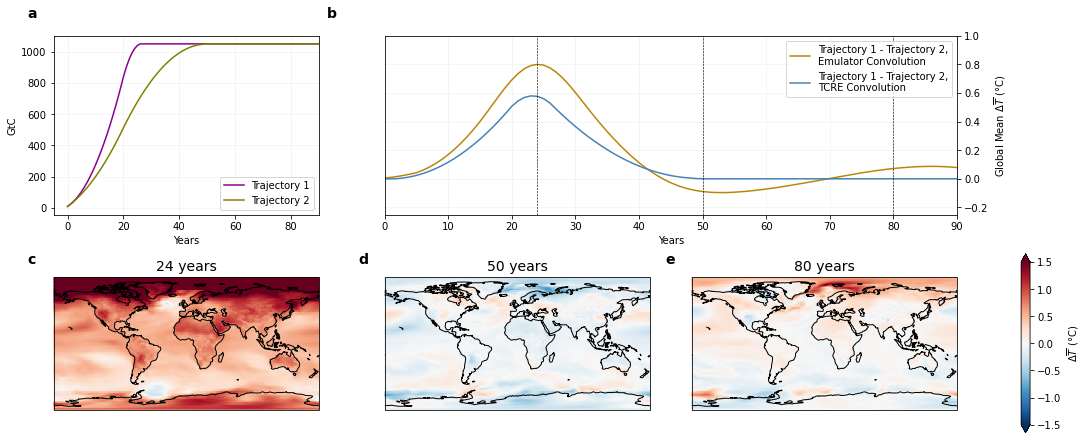

In [36]:
fig = plt.figure(figsize = [15,6], constrained_layout = True)
gs = GridSpec(2,3, figure = fig)
TCRE = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').sel(s = slice(0,70)).weighted(model_weights).mean(dim = 'model').mean().values
####### cumulative emissions ########
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.cumsum(sudden_decrease), label = 'Trajectory 1', color = 'darkmagenta')
ax1.plot(np.cumsum(slow_decrease), label = 'Trajectory 2', color = 'olive')
ax1.set_ylabel('GtC')
ax1.set_xlabel('Years')
ax1.grid(alpha = 0.15)
ax1.legend()
ax1.set_xlim(None, 90)
####### global mean ############
ax2 = fig.add_subplot(gs[0,1:])
((conv_sudden.rolling(s = 10, min_periods = 1, center = True).mean('s')-conv_slow.rolling(s = 10, min_periods = 1, center = True).mean('s'))).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Trajectory 1 - Trajectory 2,\nEmulator Convolution', color = 'darkgoldenrod')
#ax2.fill_between(np.arange(0,340),((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).roll(s = -5), ((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).roll(s = 5), alpha = .1, color = 'darkgoldenrod')
ax2.plot(np.cumsum((sudden_decrease -slow_decrease)*TCRE), label = 'Trajectory 1 - Trajectory 2,\nTCRE Convolution', color = 'steelblue')

ax2.axvline(24, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(50, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(80, linestyle = '--', color = 'k', linewidth = .6)

ax2.set_xlim(0,90)
ax2.set_ylim(-.25,1)
ax2.set_ylabel('Global Mean $\Delta \overline{T}$ ($\degree$C)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Years')
ax2.grid(alpha = 0.15)
ax2.legend()
####### Maps ###########

ax3 = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1,1], projection = ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[1,2], projection = ccrs.PlateCarree())
cbar_arg = {24:None, 50:None, 80:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = -1.5
vmax = 1.5
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax3, ax4, ax5]):
    if ax == ax3 or ax == ax4:
        add_cbar = False
    elif ax == ax5:
        add_cbar = True
    (conv_sudden-conv_slow).sel(s = slice(t-5, t+5)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)
    
#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4, ax5]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig('figures/paper/figure4_example_emissions.png', dpi = 350, bbox_inches = 'tight')

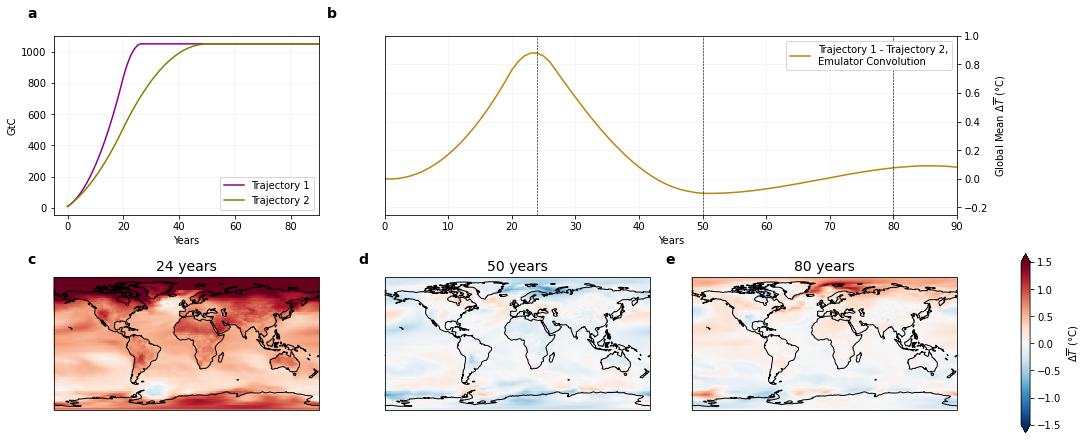

In [37]:
fig = plt.figure(figsize = [15,6], constrained_layout = True)
gs = GridSpec(2,3, figure = fig)
TCRE = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').sel(s = slice(0,70)).weighted(model_weights).mean(dim = 'model').mean().values
####### cumulative emissions ########
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.cumsum(sudden_decrease), label = 'Trajectory 1', color = 'darkmagenta')
ax1.plot(np.cumsum(slow_decrease), label = 'Trajectory 2', color = 'olive')
ax1.set_ylabel('GtC')
ax1.set_xlabel('Years')
ax1.grid(alpha = 0.15)
ax1.legend()
ax1.set_xlim(None, 90)
####### global mean ############
ax2 = fig.add_subplot(gs[0,1:])
((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Trajectory 1 - Trajectory 2,\nEmulator Convolution', color = 'darkgoldenrod')

ax2.axvline(24, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(50, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(80, linestyle = '--', color = 'k', linewidth = .6)

ax2.set_xlim(0,90)
ax2.set_ylim(-.25,1)
ax2.set_ylabel('Global Mean $\Delta \overline{T}$ ($\degree$C)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Years')
ax2.grid(alpha = 0.15)
ax2.legend()
####### Maps ###########

ax3 = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1,1], projection = ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[1,2], projection = ccrs.PlateCarree())
cbar_arg = {24:None, 50:None, 80:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = -1.5
vmax = 1.5
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax3, ax4, ax5]):
    if ax == ax3 or ax == ax4:
        add_cbar = False
    elif ax == ax5:
        add_cbar = True
    (conv_sudden-conv_slow).sel(s = slice(t-5, t+5)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)
    
#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4, ax5]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig('figures/talks/figure4_example_emissions.png', dpi = 350, bbox_inches = 'tight')

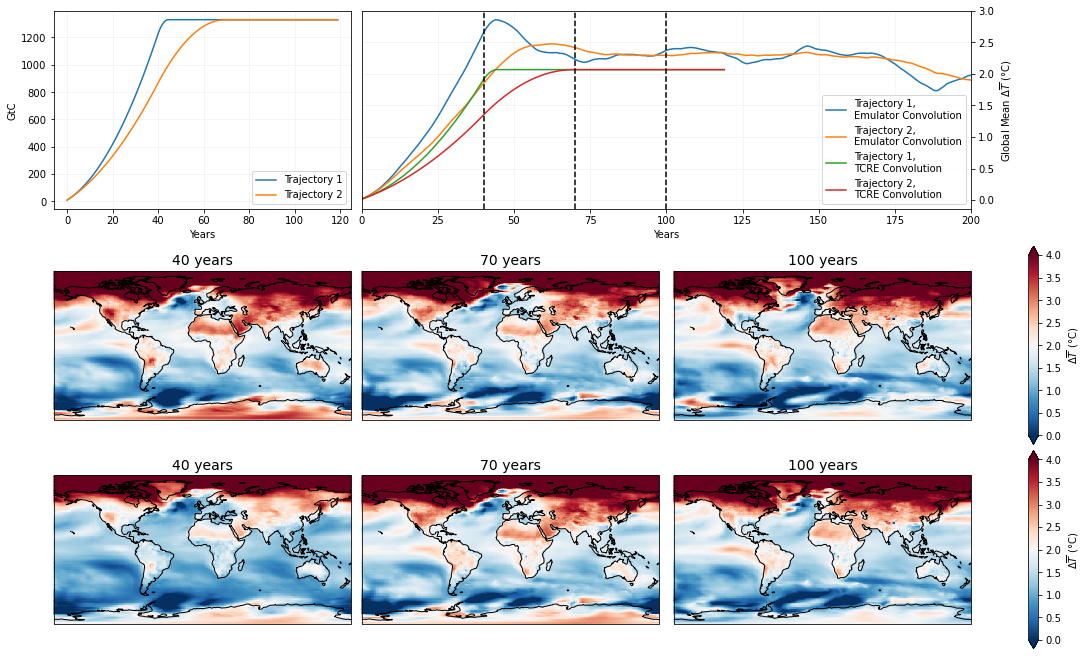

In [40]:
fig = plt.figure(figsize = [15,9], constrained_layout = True)
gs = GridSpec(3,3, figure = fig)
TCRE = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').sel(s = slice(0,70)).weighted(model_weights).mean(dim = 'model').mean().values
####### cumulative emissions ########
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.cumsum(sudden_decrease), label = 'Trajectory 1')
ax1.plot(np.cumsum(slow_decrease), label = 'Trajectory 2')
ax1.set_ylabel('GtC')
ax1.set_xlabel('Years')
ax1.grid(alpha = 0.15)
ax1.legend()
####### global mean ############
ax2 = fig.add_subplot(gs[0,1:])
(conv_sudden).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Trajectory 1,\nEmulator Convolution')
(conv_slow).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Trajectory 2,\nEmulator Convolution')

ax2.plot(np.cumsum((sudden_decrease)*TCRE), label = 'Trajectory 1,\nTCRE Convolution')
ax2.plot(np.cumsum((slow_decrease)*TCRE), label = 'Trajectory 2,\nTCRE Convolution')

ax2.axvline(40, linestyle = '--', color = 'k')
ax2.axvline(60, linestyle = '--', color = 'k')
ax2.axvline(80, linestyle = '--', color = 'k')

ax2.set_xlim(0,200)
#ax2.set_ylim(-1,1)
ax2.set_ylabel('Global Mean $\Delta \overline{T}$ ($\degree$C)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Years')
ax2.grid(alpha = 0.15)
ax2.legend()
####### Maps of trajectory 1 ###########

ax3 = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1,1], projection = ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[1,2], projection = ccrs.PlateCarree())
cbar_arg = {40:None, 70:None, 100:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = 0
vmax = 4
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax3, ax4, ax5]):
    if ax == ax3 or ax == ax4:
        add_cbar = False
    elif ax == ax5:
        add_cbar = True
    (conv_sudden).sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)
    
####### Maps ###########

ax6 = fig.add_subplot(gs[2,0], projection = ccrs.PlateCarree())
ax7 = fig.add_subplot(gs[2,1], projection = ccrs.PlateCarree())
ax8 = fig.add_subplot(gs[2,2], projection = ccrs.PlateCarree())
cbar_arg = {40:None, 70:None, 100:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = 0
vmax = 4
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax6, ax7, ax8]):
    if ax == ax6 or ax == ax7:
        add_cbar = False
    elif ax == ax8:
        add_cbar = True
    (conv_slow).sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)